In [1]:
import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
import os

path = 'D:\\MS 2.0\\NSS Project + Data\\Latest Implementation\\Data & understanding'
os.chdir(path)

### The objective is to utilize household_characteristics file (containing socio-economic variables) like primary occupation, consumer expenditure, social group, distance to nearest school, whether house has computer/internet as features in a Naive Bayes classifier to identify students at higher risk of dropping out. 

### Household_members consists of particulars of each individual within household and their relation to the head of household

### Dropouts contains particulars of individuals aged 5-29 who discontinued their education

# Reading the input data files

In [2]:
household_id = pd.read_csv("Household_identification.csv")
household_char = pd.read_csv("Household_characteristics.csv")
household_mem = pd.read_csv("Household_members.csv")
dropouts = pd.read_csv("Particulars_of_dropouts.csv")

# Household characteristics - retaining necessary information, data transformation

In [3]:
household_char = household_char[['HSIZE','HTYPE','SG_CD',"DISTANCE_PRM","DISTANCE_UPP_PRM","DISTANCE_SEC",'WHE_HH_COMP',
                                 'WHE_HH_INT','HH_CONS_EXP','ID_KEY']]
household_char.head(5)

#Checking distribution for 'Household Consumer Expenditure' and bucketing into 5 distinct groups
household_char['HH_CONS_EXP'].describe()
household_char['CONS_EXP_BUCKET'] = pd.qcut(household_char['HH_CONS_EXP'], 5, labels = False) 

# Dropouts - Data cleaning

In [4]:
dropouts.head(5)

dropouts.dropna(subset = ["SR_NO"], inplace=True)
dropouts['SR_NO'] = dropouts['SR_NO'].astype(int)

dropouts.dropna(subset = ["CLASS_COMPLETED"], inplace=True)
dropouts['CLASS_COMPLETED'] = dropouts['CLASS_COMPLETED'].astype(int) 

In [5]:
#We have particulars of dropouts in the age bracket of 5-29 years. Carrying out data cleaning steps to ensure consistency
dropouts.head(5)
dropouts.shape

dropouts = dropouts[(dropouts['AGE'] >= 5) & (dropouts['AGE'] <= 29)]

#Checking to see if column 'Enrolment Age' makes sense with respect to column 'Level enroled in'
check = dropouts.groupby(["LEVEL_CD"])['ENROLLED_AGE_FIRST'].mean()

#Based on definitions of 'Level enroled' codes, it is not possible for codes 11,13,14,15,16 to have avg enrolment age of 5.
#Hence, we remove those codes considering them as noise in our data

dropouts = dropouts[(dropouts['LEVEL_CD'] != 11) & (dropouts['LEVEL_CD'] != 13) & (dropouts['LEVEL_CD'] != 14) & 
                   (dropouts['LEVEL_CD'] != 15) & (dropouts['LEVEL_CD'] != 16)]

dropouts['LEVEL_CD'].unique()

# Since we are focusing on school level dropouts for now, we can filter 'Class Completed' for classes 1 through 10

dropouts = dropouts[(dropouts['CLASS_COMPLETED'] >= 1) & (dropouts['CLASS_COMPLETED'] <= 10) ]
dropouts.shape

# Create unique identifier for each individual using ID_KEY (Household Key) and Sr_No (Household member ID)
dropouts['Individual_ID'] = dropouts["ID_KEY"].astype(str) + dropouts["SR_NO"].astype(str)

# Household members - Data cleaning, Feature Engineering

In [6]:
household_mem.head(1)

,SR_NO,REL_HEAD,SEX,AGE,MARTIAL_STATUS_CD,EDUCATION_LVL_CD,ABL_OPR_COMP,ABL_USE_COM_TYP,ABL_USE_INT_SURF,ABL_USE_INT_MAIL,CUR_EDU_STATUS,WHE_RESI_HOSTEL,CUR_EDU_ENROLL_STATUS,SRL_NO,ELE_NO,BLK,ROUND,ID_KEY
0,1.0,1.0,1.0,45.0,2.0,15.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1,1,4,71,965938


In [7]:
# Since we are only looking at individuals who are either currently studying or recently left the education system,
# we filter for ages between 5 and 29 and filtering out necessary columns

household_mem.head(5)
household_mem.dropna(subset = ["SR_NO"], inplace=True)

household_mem['SR_NO'] = household_mem['SR_NO'].astype(int)

household_mem = household_mem[(household_mem['AGE'] >= 5) & (household_mem['AGE'] <= 29)]
household_mem = household_mem[['SR_NO','REL_HEAD','SEX','AGE','MARTIAL_STATUS_CD','CUR_EDU_STATUS','WHE_RESI_HOSTEL','CUR_EDU_ENROLL_STATUS','ID_KEY']]

# To train our Naive Bayes classifier, let us consider a list of students who are currently unenroled,
# and students who are currently enroled upto higher secondary level
household_mem = household_mem[(household_mem["CUR_EDU_ENROLL_STATUS"] >= 1) & (household_mem["CUR_EDU_ENROLL_STATUS"] <= 13)] 

# Create unique identifier for each individual using ID_KEY (Household Key) and Sr_No (Household member ID)
household_mem['Individual_ID'] = household_mem["ID_KEY"].astype(str) + household_mem["SR_NO"].astype(str)

In [8]:
household_mem.shape

(4398, 10)

# Combining all above data frames to get base data for Naive Bayes 

In [9]:
dropouts = dropouts[['Individual_ID','CLASS_COMPLETED']]
household_char = household_char[['HSIZE','HTYPE','SG_CD',"DISTANCE_PRM","DISTANCE_UPP_PRM",
                                 "DISTANCE_SEC",'WHE_HH_COMP','WHE_HH_INT','CONS_EXP_BUCKET','ID_KEY']]

In [10]:
#Getting particulars of dropouts and characteristics of the household into a single data frame
combined_data = pd.merge(household_mem, dropouts, how = 'left', on = 'Individual_ID')
combined_data = pd.merge(combined_data, household_char, how = 'left', on = 'ID_KEY')
combined_data.head(10)

#Adding a flag for dropouts in our dataset. 1 for dropout, 0 for not (This will be our Target variable for Naive Bayes model)
combined_data['Dropout'] = [1 if x in [1,2,3,4,5,6,7,8,9,10] else 0 for x in combined_data["CLASS_COMPLETED"]]
combined_data.head(20)
combined_data.groupby('Dropout')['Individual_ID'].nunique()

Dropout
0    2536
1    1862
Name: Individual_ID, dtype: int64

In [11]:
combined_data.head()

NB_data = combined_data[["REL_HEAD","SEX","AGE","MARTIAL_STATUS_CD","HSIZE","HTYPE","SG_CD",'DISTANCE_PRM','DISTANCE_UPP_PRM',
                         'DISTANCE_SEC','WHE_HH_COMP','WHE_HH_INT','CONS_EXP_BUCKET',"Dropout"]]
NB_data = NB_data.dropna()
NB_data.head(5)

,REL_HEAD,SEX,AGE,MARTIAL_STATUS_CD,HSIZE,HTYPE,SG_CD,DISTANCE_PRM,DISTANCE_UPP_PRM,DISTANCE_SEC,WHE_HH_COMP,WHE_HH_INT,CONS_EXP_BUCKET,Dropout
0,2.0,2.0,25.0,2.0,2.0,1.0,9.0,1.0,2.0,2.0,2.0,2.0,0.0,1
1,5.0,1.0,21.0,1.0,4.0,1.0,3.0,1.0,1.0,1.0,2.0,2.0,1.0,1
2,5.0,1.0,12.0,1.0,5.0,1.0,9.0,1.0,2.0,2.0,2.0,2.0,0.0,0
3,5.0,1.0,16.0,1.0,5.0,1.0,9.0,1.0,2.0,2.0,2.0,2.0,0.0,0
4,5.0,2.0,10.0,1.0,5.0,1.0,9.0,1.0,2.0,2.0,2.0,2.0,0.0,0


# PCA for dimensionality reduction

In [12]:
from sklearn.decomposition import PCA
from matplotlib import style

In [13]:
features = list(zip(NB_data['REL_HEAD'],NB_data['SEX'],NB_data['HSIZE'],NB_data['AGE'], NB_data['MARTIAL_STATUS_CD'],
                    NB_data['HTYPE'],NB_data['SG_CD'],NB_data['DISTANCE_PRM'],NB_data['DISTANCE_SEC'],NB_data['WHE_HH_COMP'],
                    NB_data['WHE_HH_INT'],NB_data['CONS_EXP_BUCKET']))

label = NB_data['Dropout']

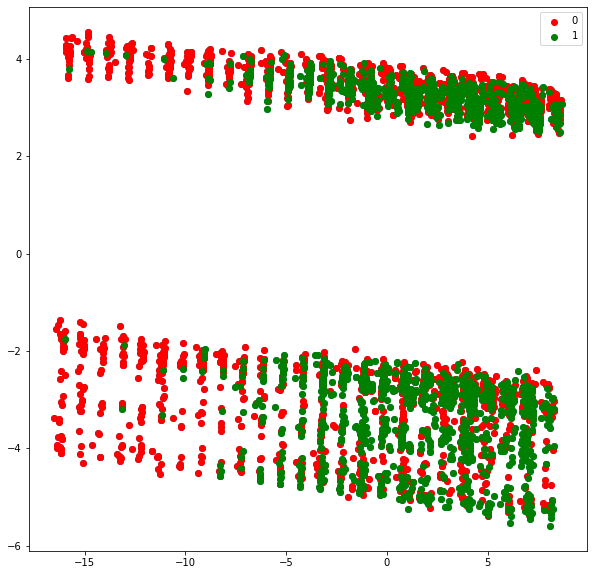

In [14]:
PCA_model = PCA(n_components=12,random_state=42)

data_transformed = PCA_model.fit_transform(NB_data,label)*(-1)


fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(111)


ax0.scatter(data_transformed.T[0],data_transformed.T[1])
for l,c in zip((np.unique(label)),['red','green','blue']):
    ax0.scatter(data_transformed.T[0,label==l],data_transformed.T[1,label==l],c=c,label=l)

ax0.legend()



plt.show()

In [15]:
data_transformed

array([[ 4.47782714,  2.7830753 ,  4.29123626, ..., -0.07380668,
        -0.13845775,  0.22286602],
       [-0.16934695, -2.59604969,  1.34465139, ...,  0.73813007,
        -0.17525905, -0.01062422],
       [-8.86330389,  3.60833423,  1.27075582, ...,  0.2461769 ,
         0.31181072,  0.26865077],
       ...,
       [-4.15153475, -3.11994281,  0.07016801, ..., -0.55859379,
         0.09612373,  0.07914597],
       [ 6.09392344,  3.2712023 ,  1.04470989, ...,  0.13188191,
         0.28041893,  0.13537722],
       [ 8.07338345,  3.17850448,  0.97012463, ...,  0.11917813,
         0.31101497,  0.13021624]])

# Naive Bayes Model

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [17]:
X_train, X_test, y_train, y_test = train_test_split(data_transformed, label, test_size=0.2,random_state=109)

In [18]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
y_pred = model.fit(X_train,y_train).predict(X_test)
y_prob = model.fit(X_train,y_train).predict_proba(X_test)

In [19]:
print("Number of mislabeled points out of a total %d points : %d"
       % (len(X_test), (y_test != y_pred).sum()))

#y_pred

Number of mislabeled points out of a total 861 points : 3


In [20]:
confusion_matrix(y_test, y_pred)

array([[512,   0],
       [  3, 346]], dtype=int64)

In [21]:
type(y_prob)

numpy.ndarray

In [22]:
Testing_data = np.column_stack((X_test, y_test, y_pred, y_prob))
Testing_data.shape

(861, 16)

In [23]:
Testing_output = pd.DataFrame({'Feature1': Testing_data[:, 0], 'Feature2': Testing_data[:, 1], 'Feature3': Testing_data[:, 2],
                               'Feature4': Testing_data[:, 3],'Feature5': Testing_data[:, 4],'Feature6': Testing_data[:, 5],
                               'Feature7': Testing_data[:, 6],'Feature8': Testing_data[:, 7],'Feature9': Testing_data[:, 8],
                               'Feature10': Testing_data[:, 9],'Feature11': Testing_data[:, 10],'Feature12': Testing_data[:, 11],
                               'Dropout_Flag': Testing_data[:, 12],'Dropout_Prediction': Testing_data[:, 13],
                               'Probability_0': Testing_data[:, 14],'Probability_1': Testing_data[:, 15],})

In [24]:
Testing_output.head(5)

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,Feature11,Feature12,Dropout_Flag,Dropout_Prediction,Probability_0,Probability_1
0,3.024308,2.962937,1.856483,0.782304,0.150485,-3.076271,-0.644588,-1.011569,-0.036444,0.662926,-0.196389,-1.488156,1.0,1.0,0.030263,0.969737
1,3.994491,-3.838898,-0.333743,1.212049,-0.818522,0.866682,-0.913599,-0.087083,0.028076,0.629404,-0.152059,-0.044830,1.0,1.0,0.068498,0.931502
2,5.547270,3.645260,-5.733961,-0.329941,4.018681,-0.681461,-0.493330,0.009627,-0.166700,0.519773,0.785093,0.093096,0.0,0.0,0.995384,0.004616
3,-11.686937,4.235749,1.512289,0.545148,0.525135,2.153887,1.874638,0.132846,-0.238268,-0.597994,-0.310800,0.212354,0.0,0.0,0.980823,0.019177
4,2.104262,3.141267,-5.588404,0.364995,-2.980180,-1.662933,-1.973960,-0.386493,-0.388592,-0.204919,-0.445128,0.115711,1.0,1.0,0.083351,0.916649


In [25]:
def Flag(x):
    if (x['Dropout_Flag'] == x['Dropout_Prediction'] ) : 
        return 'Correct Pred'
    if (x['Dropout_Flag'] > x['Dropout_Prediction'] ) : 
        return 'False Negative'
    if (x['Dropout_Flag'] < x['Dropout_Prediction'] ) : 
        return 'False Positive'
    


Testing_output['Prediction_Flag'] = Testing_output.apply(Flag, axis = 1)

Testing_output['Prediction_Flag'].unique()

summary = Testing_output.groupby('Prediction_Flag').agg({'Probability_0' : ['min','max'],'Probability_1' : ['min','max']} )

In [26]:
summary

Probability_0           Probability_1          
                          min       max           min       max
Prediction_Flag                                                
Correct Pred         0.008940  1.000000  8.501727e-38  0.991060
False Negative       0.619046  0.788824  2.111760e-01  0.380954

In [27]:
Testing_output.to_csv("Testing_output.csv")

# Predict probability of dropouts for all students currently studying at primary level and above (Current_students.csv), using our trained model

In [28]:
#Current_students.csv contains education particulars of students currently studying at primarly level and above  
current_students = pd.read_csv("Current_students.csv")
household_mem = pd.read_csv("Household_members.csv")

# Again, considering ages between 5-29 for current students
current_students = current_students[(current_students['AGE'] >= 5) & (current_students['AGE'] <= 29)]
current_students.head()

# Create unique identifier for each individual using ID_KEY (Household Key) and Sr_No (Household member ID)
current_students.dropna(subset = ["SR_NO"], inplace=True)
current_students['SR_NO'] = current_students['SR_NO'].astype(int)
current_students['Individual_ID'] = current_students["ID_KEY"].astype(str) + current_students["SR_NO"].astype(str)

# Subsetting individual level variables to be brought into the data from household_members
household_mem = household_mem[household_mem['CUR_EDU_STATUS'] == 7] #Education status code for students in primary and above
household_mem.shape
household_mem.dropna(subset = ["SR_NO"], inplace=True)
household_mem['SR_NO'] = household_mem['SR_NO'].astype(int)
household_mem['Individual_ID'] = household_mem["ID_KEY"].astype(str) + household_mem["SR_NO"].astype(str)

individual_var = household_mem[['REL_HEAD','SEX','MARTIAL_STATUS_CD','Individual_ID']]
individual_var.shape

(9032, 4)

(9075, 49)

In [30]:
# Adding household level variables from household_char, individual variables from individual_var
all_variables = pd.merge(current_students, household_char, how = 'left', on = 'ID_KEY')
all_variables = pd.merge(all_variables, individual_var, how = 'left', on = 'Individual_ID')

#Subsetting to include features variables required to run Naive Bayes model
socioeconomic_variables = all_variables[["REL_HEAD","SEX","AGE","MARTIAL_STATUS_CD","HSIZE","HTYPE","SG_CD",'DISTANCE_PRM',
                                         'DISTANCE_UPP_PRM',
                                         'DISTANCE_SEC','WHE_HH_COMP','WHE_HH_INT','CONS_EXP_BUCKET', 'Individual_ID']]
socioeconomic_variables = socioeconomic_variables.dropna()
socioeconomic_variables.shape

(8473, 14)

# Data transformation

In [31]:
NB_input = socioeconomic_variables[["REL_HEAD","SEX","AGE","MARTIAL_STATUS_CD","HSIZE","HTYPE","SG_CD",'DISTANCE_PRM','DISTANCE_UPP_PRM',
                                    'DISTANCE_SEC','WHE_HH_COMP','WHE_HH_INT','CONS_EXP_BUCKET']]
NB_input = NB_input.dropna()

NB_transformedInput = PCA_model.fit_transform(NB_input)*(-1)

In [41]:
#NB_input.shape
combined_output.shape


(8473, 3)

In [64]:
# aggregating Outputs of NB
predictions = model.predict(NB_transformedInput)
probabilities = model.predict_proba(NB_transformedInput)

combined_output = np.column_stack((predictions,probabilities))
combined_output.shape

# aggregating Outputs of NB into a dataframe along with the current student variables
combined_output = pd.DataFrame({'DropoutPrediction': combined_output[:, 0], 'Probability_NoDrop': combined_output[:, 1],
                                'Probability_Drop': combined_output[:, 2]})

Individual_IDs = pd.DataFrame(socioeconomic_variables['Individual_ID'])
Individual_IDs = Individual_IDs.reset_index()
CurrentStudents_Predictions = pd.concat([Individual_IDs, combined_output], axis=1, ignore_index=False)
CurrentStudents_Predictions = pd.merge(CurrentStudents_Predictions,current_students, how='inner', on = 'Individual_ID' )


### 1. Identify target students at high risk of dropping out

In [67]:
# Although our model has no false positives, we will only consider students with a predicted dropout probability > 75% 
Target_students = CurrentStudents_Predictions[(CurrentStudents_Predictions['Probability_Drop'] > 0.75) & 
                                              (CurrentStudents_Predictions['DropoutPrediction'] == 1)]
Target_students.shape

(2380, 41)

In [75]:
# Removing students that have their education fully funded (Education_Free_Code = 1) 
Target_students = Target_students[(Target_students['EDUCATION_FREE'] != 1)]

Target_students.shape

(1755, 41)

## Now to predict subsidy amounts, the steps are -
### 1. Create training data containing particulars of education expenses for K-nearest-neighbors regression model 
### 2. Predict subsidy/scholarship amount for target students by building KNN model from scratch

In [99]:
# Bringing in target variable 'Total educational expenditure' from educational expenditure data of current students 
CurrentStudent_Expenses = pd.read_csv("CurrentStudents_EducationExpenses.csv")
CurrentStudent_Expenses.dropna(subset = ["SR_NO"], inplace=True)
CurrentStudent_Expenses['SR_NO'] = CurrentStudent_Expenses['SR_NO'].astype(int)
CurrentStudent_Expenses['Individual_ID'] = CurrentStudent_Expenses["ID_KEY"].astype(str) + CurrentStudent_Expenses["SR_NO"].astype(str)
    
CurrentStudent_Expenses = CurrentStudent_Expenses[(CurrentStudent_Expenses['AGE'] >= 5) & (CurrentStudent_Expenses['AGE'] <= 29)]
CurrentStudent_Expenses = CurrentStudent_Expenses[['Individual_ID','TOTAL_EXPENDITURE']]

education_particulars =  pd.merge(current_students, CurrentStudent_Expenses,on = 'Individual_ID', how='inner')

In [103]:
list(education_particulars.columns)
education_particulars = education_particulars[['LEV_CURR_ATTEND','COURSE_CD','INSTITUTION_CD','TYPE_COURSE_CD','FEE_WAIVED',
                                               'RECVD_TXT_BOOK_CD','RECVD_STAT_CD','FREE_MID_DAY_MEAL',
                                               'TRANSPORT_CD','DIST_RESIDENCE','TOTAL_EXPENDITURE']]
education_particulars = education_particulars.dropna()

education_particulars.shape

(5656, 11)

In [107]:
# Creating list of variables to be considered while computing subsidy amount using KNN
feature_list = ['LEV_CURR_ATTEND','COURSE_CD','INSTITUTION_CD','TYPE_COURSE_CD','FEE_WAIVED',
                 'RECVD_TXT_BOOK_CD','RECVD_STAT_CD','FREE_MID_DAY_MEAL','TRANSPORT_CD','DIST_RESIDENCE']

In [108]:
def get_numpy_data(data_frame, features, output):
    data_frame['constant'] = 1 # add constant column
    features = ['constant'] + features 
    features_frame = data_frame[features]
    feature_matrix = features_frame.to_numpy()
    output_array = data_frame[output]
    output_array = output_array.to_numpy()
    return(feature_matrix, output_array)

In [109]:
def normalize_features(feature_matrix):
    norms = np.linalg.norm(feature_matrix, axis=0)
    normalized_features = feature_matrix/norms
    return(normalized_features,norms)

In [110]:
train_and_validation, test = train_test_split(education_particulars, test_size=0.2,random_state=109)
train, validation = train_test_split(train_and_validation, test_size=0.2,random_state=109)

In [111]:
features_train, output_train = get_numpy_data(train, feature_list, 'TOTAL_EXPENDITURE')
features_test, output_test = get_numpy_data(test, feature_list, 'TOTAL_EXPENDITURE')
features_valid, output_valid = get_numpy_data(validation, feature_list, 'TOTAL_EXPENDITURE')

<ipython-input-108-769ee97a4a09>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame['constant'] = 1 # add constant column


In [112]:
features_train, norms = normalize_features(features_train) # normalize training set features (columns)
features_test = features_test / norms # normalize test set by training set norms
features_valid = features_valid / norms # normalize validation set by training set norms

In [114]:
euclidean_distance = np.sqrt(np.sum((features_train[9] - features_test[0])**2))
print(euclidean_distance)

0.019455192128930838


In [115]:
def compute_distance(train_features,query):
    diff = train_features - query
    dist = np.sqrt(np.sum(diff**2, axis=1))
    return dist

In [116]:
def k_nearest_neighbors(k,feature_train, query):
    distances = compute_distance(feature_train, query)
    return np.argsort(distances, axis=0)[:k]

In [124]:
train = train.reset_index()

In [132]:
dist_arr = compute_distance(features_train, features_test[2])
print(np.argmin(dist_arr))
train.iloc[2966]['TOTAL_EXPENDITURE']

31


6900.0

In [134]:
neighbors = k_nearest_neighbors(4,features_train,features_test[2])
print(neighbors)

[3618 3048 1364 1359]


In [164]:
def predict_value(k, features_train,output_train,query):
    neighbors = k_nearest_neighbors(k,features_train, query)
    sum = 0
    for i in neighbors:
        sum = sum + output_train[i]
    price = sum/k
    return price

In [165]:
def multiple_predictions(k, features_train, output_train, query):
    num_of_rows = query.shape[0]
    predicted_values = []
    for i in range(num_of_rows):
        value = predict_value(k,features_train, output_train,query[i])
        predicted_values.append(value)
    return predicted_values

In [138]:
rss_all = []
for k in range(1,16):
    value = multiple_predictions(k, features_train,output_train,features_valid)
    residual = (output_valid - value)
    rss = sum(residual**2)
    rss_all.append(rss)
print(rss_all)

[2489761245129.0, 2785002388991.5, 2315792166703.9883, 2149473806964.9375, 2031743765725.0, 2037643818734.5493, 1951636920857.5723, 1907267142634.8594, 1879465799733.3167, 1847398302921.75, 1832549887936.4597, 1807237539776.5852, 1788825570513.6326, 1772801860294.0547, 1754791316967.5532]


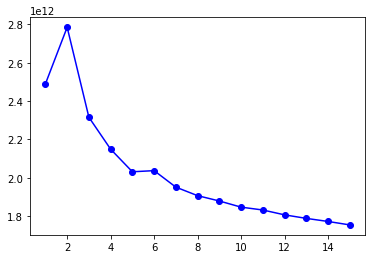

In [139]:
import matplotlib.pyplot as plt
%matplotlib inline

kvals = range(1, 16)
plt.plot(kvals, rss_all,'bo-')

## Now, transforming target students' educational particulars as required for KNN, and predicting amounts

In [160]:
def get_transformed_data(data_sframe, features):
    data_sframe['constant'] = 1 # add constant column
    features = ['constant'] + features 
    features_sframe = data_sframe[features]
    feature_matrix = features_sframe.to_numpy()
    return(feature_matrix)

In [180]:
Target_students = Target_students[feature_list]

Target_features = get_transformed_data(Target_students, feature_list)

Target_features = Target_features / norms

Subsidy_Amounts = pd.Series(multiple_predictions(14, features_train, output_train, Target_features))
len(Subsidy_Amounts)

1755

In [181]:
Target_students = Target_students.reset_index()
TargetStudent_Subsidies = pd.concat([Target_students, Subsidy_Amounts], axis=1, ignore_index=False)
TargetStudent_Subsidies.shape

(1755, 13)